# Experimental validations

The pipeline of Mini-AutoML needs to be run prior to this notebook, in order to obtain predictions across the Enamine stock compounds. That pipeline will genereate, in an `assets` folder, the following files:

- `cross_validation_results.csv`
- `enamine_stock_predictions_enamine_stock.csv`

In addition, we use the `validation.tsv` file, containing experimental results from December 2022.

The current notebook also expects that the `InteractomeSignatures.ipynb` notebook has been run previously.

In [1]:
import pandas as pd
import csv
import os
import json
import shutil
import numpy as np
import joblib
import collections
import h5py
import blitzgsea as blitz
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from scipy.stats import fisher_exact
import stylia
from stylia.colors import ContinuousColorMap
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

with open("../results/topwiz_maxpxf100_minp4_maxp40/metadata.json", "r") as f:
    metadata = json.load(f)
    
MAX_PROTEIN_COUNTS = metadata["MAX_PROTEIN_COUNTS"]
MIN_PROTEIN_COUNTS = metadata["MIN_PROTEIN_COUNTS"]
MAX_PROTEINS_PER_FRAGMENTS = metadata["MAX_PROTEINS_PER_FRAGMENTS"]
MIN_PROTEINS_PER_FRAGMENTS = metadata["MIN_PROTEINS_PER_FRAGMENTS"]
TFIDF = metadata["TFIDF"]
    
cv = pd.read_csv("../results/topwiz_maxpxf100_minp4_maxp40/modeling_validations/validation_summary.csv")
dp = pd.read_csv("../results/topwiz_maxpxf100_minp4_maxp40/modeling_validations/enamine_predictions.csv")
#dp = pd.read_csv("../data/2303_EnamineStockPredictions_Predictions.csv")[list(dp.columns)]
tested = pd.read_csv("../data/2212_tested_enamine_compounds.csv")[["catalog_id", "fid", "original_validation"]]
dp = tested.merge(dp, on="catalog_id", how="right")
df = pd.read_csv("../data/validation.tsv", sep="\t")
df = df[df["Number_of_Protein_Unique_Peptides"] >= 2]
pid2name = {}
with open("../data/pid2name_primary_all.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        pid2name[r[0]] = r[1]

results_folder = "../results/topwiz_maxpxf100_minp4_maxp40"
output_folder = results_folder.replace("topwiz_", "validation_")

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)

frag_ids = []
for fid in dp["fid"].tolist():
    if str(fid) == "nan":
        frag_ids += [np.nan]
    else:
        frag_id = fid.split("-")[1]
        if len(frag_id) == 5:
            frag_ids += [frag_id]
        else:
            if frag_id == "V059":
                frag_id = "V0081"
            elif frag_id == "V060":
                frag_id = "V0157"
            elif frag_id == "V062":
                frag_id = "V0302"
            elif frag_id == "V065":
                frag_id = "V0480"
            else:
                frag_id = frag_id.replace("V", "V0")
            frag_ids += [frag_id]
dp["FragID"] = frag_ids

tested_fids = sorted(set(df["FragID"]))

pht = pd.read_csv(os.path.join(results_folder, "ProteinHasTopic.csv"))
topic_names = list(pht.columns)[4:]
NUM_TOPICS = len(topic_names)

local_proteins = set(pht["gene_name"])

def tokenizer(x):
    return x.split(" ")

data_for_wizard = joblib.load(os.path.join(results_folder, "data_for_wizard.joblib"))

def get_X_from_esm():
    with h5py.File("../data/pid2seq_esm1b.h5", "r") as f:
        the_pids = [x.decode("utf-8") for x in f["Keys"][:]]
        X = f["Values"][:]
        the_pids_idxs = dict((k,i) for i,k in enumerate(the_pids))
    return X, the_pids, the_pids_idxs

def get_X_from_bioteque(metapath_name="gene_has_cmp"):
    with h5py.File("../data/bioteque/{0}/GEN_emb.h5".format(metapath_name), "r") as f:
        X = f["m"][:]
    with open("../data/bioteque/{0}/GEN_ids.txt".format(metapath_name), "r") as f:
        the_pids = []
        for l in f:
            the_pids += [l.rstrip()]
    the_pids_idxs = dict((k,i) for i,k in enumerate(the_pids))
    return X, the_pids, the_pids_idxs

def get_X_merged(n_components=300):
    X_1, the_pids_1, the_pids_idxs_1 = get_X_from_bioteque("gene_has_cmp")
    X_2, the_pids_2, the_pids_idxs_2 = get_X_from_esm()
    the_pids = sorted(set(the_pids_1).intersection(the_pids_2))
    R = []
    for pid in the_pids:
        r = [x for x in X_1[the_pids_idxs_1[pid]]] + [x for x in X_2[the_pids_idxs_2[pid]]]
        R += [r]
    X = np.array(R)
    X = PCA(n_components=n_components).fit_transform(X)
    the_pids_idxs = dict((k,i) for i,k in enumerate(the_pids))
    return X, the_pids, the_pids_idxs

X_emb, emb_pids, emb_pids_idxs = get_X_merged()

db = pd.read_csv("../data/cemm_primary_hit_data.tsv", sep="\t")

fids = sorted(set(df["FragID"]))
fid2smi = pd.read_csv("../data/fid2can_fff_all.tsv", sep="\t")
fid2smi = fid2smi[fid2smi["fid"].isin(fids)].sort_values("fid")
fid2smi_dict = {}
for r in fid2smi.values:
    fid2smi_dict[r[0]] = r[1]

pid2name = {}
with open("../data/pid2name_primary_all.tsv", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for r in reader:
        pid2name[r[0]] = r[1]

protein_counts = collections.defaultdict(int)
for r in db["UniProtID"].tolist():
    protein_counts[r] += 1
protein_counts = sorted(protein_counts.items(), key=lambda x: -x[1])

fragment_counts = collections.defaultdict(int)
for r in db["FragID"].tolist():
    fragment_counts[r] += 1
fragment_counts = sorted(fragment_counts.items(), key=lambda x: -x[1])

protein_counts = collections.defaultdict(int)
for r in db["UniProtID"].tolist():
    protein_counts[r] += 1

max_counts = MAX_PROTEIN_COUNTS
pids = sorted(set(db["UniProtID"]))
pids = [x for x in pids if protein_counts[x] <= max_counts]
min_counts = MIN_PROTEIN_COUNTS
pids = [x for x in pids if protein_counts[x] >= min_counts]
pids = sorted(set(pids).intersection(emb_pids))

emb_idxs = []
for pid in pids:
    emb_idxs += [emb_pids_idxs[pid]]
X_emb = X_emb[emb_idxs]

pid2idx = dict((k,i) for i,k in enumerate(pids))
pids_set = set(pids)

fids = sorted(set(df["FragID"]))
fid2idx = dict((k,i) for i,k in enumerate(fids))

Y_pro = np.full((len(fids), len(pids)), np.nan)

cols = [
    "FragID",
    "Accession",
    "Number_of_Protein_Unique_Peptides",
    "Rank_relative",
    "Abundance_Ratio_log2",
    "Abundance_Ratio_log2_median_corr",
    "Abundance_Ratio_PValue",
    "Abundance_Ratio_Adj_PValue"
]

for r in df[cols].values:
    if r[1] not in pids_set:
        continue
    i = fid2idx[r[0]]
    j = pid2idx[r[1]]
    unique_peptides = float(r[2])
    rank_relative = float(r[3])
    log2fc = float(r[4])
    log2fc_median = float(r[5])
    p_value = float(r[6])
    p_value_adj = float(r[7])
    if unique_peptides < 2:
        continue
    if np.isnan(p_value):
        continue
    if np.isnan(log2fc):
        continue
    Y_pro[i,j] = log2fc

R_pro = np.array(Y_pro)
R_pro[np.isnan(R_pro)] = -999

def read_annotations(annotations_file):
    d = collections.defaultdict(list)
    with open(annotations_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for r in reader:
            if r[0] not in pid2name:
                continue
            d[r[1]] += [pid2name[r[0]]]
    d = dict((k, set(v)) for k,v in d.items() if len(v) >= 5)
    return d

cc_annotations = read_annotations("../data/msigdb_gocc.tsv")
mf_annotations = read_annotations("../data/msigdb_gomf.tsv")

In [2]:
%%capture

gsea_prefiltering_file = os.path.join(output_folder, "gsea_prefiltering_minp{0}_maxp{1}.joblib".format(MIN_PROTEIN_COUNTS, MAX_PROTEIN_COUNTS))

if os.path.exists(gsea_prefiltering_file):
    gsea_prefiltering_results = joblib.load(gsea_prefiltering_file)
else:
    gsea_prefiltering_results = []
    for i in range(R_pro.shape[0]):
        v = np.array(R_pro[i,:])
        mask = v != -999
        pids_ = [pids[i] for i in range(len(v)) if mask[i]]
        v_ = PowerTransformer().fit_transform(v[mask].reshape(-1,1))[:,0]
        genes_ = [pid2name[p] for p in pids_]
        signature = pd.DataFrame({0: genes_, 1: v_})
        cc_ = dict((k,list(v.intersection(genes_))) for k,v in cc_annotations.items())
        mf_ = dict((k,list(v.intersection(genes_))) for k,v in mf_annotations.items())
        cc_ = dict((k,v) for k,v in cc_.items() if len(v) >= 5)
        mf_ = dict((k,v) for k,v in mf_.items() if len(v) >= 5)
        result_cc = blitz.gsea(signature, cc_, anchors=4, permutations=2000, processes=4, signature_cache=True)
        result_mf = blitz.gsea(signature, mf_, anchors=4, permutations=2000, processes=4, signature_cache=True)
        gsea_prefiltering_results += [(fids[i], signature, result_cc, result_mf)]
    joblib.dump(gsea_prefiltering_results, gsea_prefiltering_file)

In [3]:
def do_documents_list(min_proteins_per_fragment):
    gsea_pval = 0.05
    documents_list = []
    cap = 250
    hits = []
    for fid in fids:
        pids_ = db[db["FragID"] == fid]["UniProtID"]
        pids_ = set(pids_).intersection(pids)
        genes_ = [pid2name[p] for p in pids_]
        hits += [set(genes_)]
    gid2idx = dict((pid2name[k],i) for i,k in enumerate(pids))
    for i in range(R_pro.shape[0]):
        gs = gsea_prefiltering_results[i]
        cc = gs[2]
        cc = cc[cc["pval"] < gsea_pval]
        mf = gs[3]
        mf = mf[mf["pval"] < gsea_pval]
        cc_genes = [g for x in cc["leading_edge"].tolist() for g in x.split(",")]
        mf_genes = [g for x in mf["leading_edge"].tolist() for g in x.split(",")]
        le = list(cc_genes + mf_genes)
        le = set([x for x in le if x != ""])
        v = R_pro[i,:]
        idxs = np.argsort(v)[::-1][:cap]
        pids_ = [pids[i] for i in idxs]
        genes_base = [pid2name[p] for p in pids_]
        genes_ = [g for g in genes_base if g in le]
        if len(genes_) > MAX_PROTEINS_PER_FRAGMENTS:
            genes_ = genes_[:MAX_PROTEINS_PER_FRAGMENTS]
        else:
            if len(genes_) < min_proteins_per_fragment:
                missing = min_proteins_per_fragment - len(genes_)
                ht = hits[i]
                exclusive_ht = ht.difference(le)
                if len(exclusive_ht) >= missing:
                    eh_list = list(exclusive_ht)
                    le_list = list(le)
                    eh_idxs = [gid2idx[k] for k in eh_list]
                    le_idxs = [gid2idx[k] for k in le_list]
                    nn = NearestNeighbors(n_neighbors=3)
                    nn.fit(X_emb[le_idxs])
                    I, D = nn.kneighbors(X_emb[eh_idxs])
                    dists = np.mean(D, axis=1)
                    idxs_ = np.argsort(dists)[:missing]
                    sel_eh = set([eh_list[idx] for idx in idxs_])
                    genes_ = [g for g in genes_base if g in le or g in sel_eh]
                else:
                    genes_ = [g for g in genes_base if g in le or g in ht]
                    missing = min_proteins_per_fragment - len(genes_)
                    eb_list = [g for g in genes_base if g not in genes_]
                    eb_idxs = [gid2idx[k] for k in eb_list]
                    le_list = list(le)
                    le_idxs = [gid2idx[k] for k in le_list]
                    nn = NearestNeighbors(n_neighbors=3)
                    nn.fit(X_emb[le_idxs])
                    I, D = nn.kneighbors(X_emb[eb_idxs])
                    dists = np.mean(D, axis=1)
                    idxs_ = np.argsort(dists)[:missing]
                    sel_eb = set([eb_list[idx] for idx in idxs_])
                    genes_ = [g for g in genes_base if g in le or g in ht or g in sel_eb]
            else:
                pass
        documents_list += [genes_]
    return documents_list

def create_documents():
    f0 = open("{0}/gene_docs.txt".format(output_folder), "w")
    f1 = open("{0}/fids.txt".format(output_folder), "w")
    for i, g in enumerate(documents_list):
        f0.write(" ".join(g) + "\n")
        f1.write(fids[i] + "\n")
    f0.close()
    f1.close()

documents_list = do_documents_list(MIN_PROTEINS_PER_FRAGMENTS)
create_documents()

def get_texts():
    with open("{0}/gene_docs.txt".format(output_folder), "r") as f:
        texts = [x.rstrip() for x in f.readlines()]
    return texts

texts = get_texts()

In [4]:
def get_texts_simple(top_n):
    idx2pid = dict((v,k) for k,v in pid2idx.items())
    texts = []
    for i in range(R_pro.shape[0]):
        idxs = np.argsort(R_pro[i,:])[::-1]
        idxs = idxs[:top_n]
        my_pids = [idx2pid[i] for i in idxs]
        my_gens = [pid2name[p] for p in my_pids]
        texts += [" ".join(my_gens)]
    return texts

texts_simple = get_texts_simple(25)

In [5]:
def get_prediction_score(topic_i, fid):
    r = dp[dp["FragID"]==fid]["signature_{0}".format(topic_i)]
    return float(r)

def calculate_enrichment(topic_i, fid, top_t, top_s, local):
    d = df[df["FragID"] == fid][["Accession", "Abundance_Ratio_log2"]]
    d = [(pid2name[x[0]], x[1]) for x in d.values if str(x[1]) != "nan"]
    d = sorted(d, key=lambda x: -x[1])
    if local:
        d = [x for x in d if x[0] in local_proteins]
    t = [tuple(x) for x in pht[["gene_name", "signature_{0}".format(topic_i)]].values]
    t = sorted(t, key=lambda x: -x[1])
    n = len(t)
    t = set([x[0] for x in t][:top_t]).intersection(local_proteins)
    d = set([x[0] for x in d][:top_s]).intersection(local_proteins)
    a = len(t.intersection(d))
    b = len(t)
    c = len(d)
    d = n - (a+b+c)
    M = [[a,b],[c,d]]
    odds, p_value = fisher_exact([[a,b],[c,d]], alternative="greater")
    results = {
        "m": M,
        "odds_ratio": odds,
        "p_value": p_value
    }
    return results

def calculate_topic_association(W, topic_i, fid):
    j = tested_fids.index(fid)
    return W[j, topic_i]
    

In [31]:
cmap = ContinuousColorMap()
cmap.fit([i for i in range(NUM_TOPICS)])
colors = cmap.transform([i for i in range(NUM_TOPICS)])

def roc_plot(ax, topic_i, sufix=40):
    x = np.arange(0,1.01,0.01)
    mdl_validation_metrics = joblib.load(os.path.join(results_folder, "modeling_validations", "validation_metrics.joblib".format(sufix)))
    idx = topic_i
    results = mdl_validation_metrics[idx]
    n_splits = results["n_splits"]
    ys = []
    for i in range(n_splits):
        fpr = results["fprs"][i]
        tpr = results["tprs"][i]
        ys += [np.interp(x, fpr, tpr)]
    ys = np.array(ys)
    y_mean = np.array([0] + list(np.mean(ys, axis=0)))
    y_std = np.array([0] + list(np.std(ys, axis=0)))
    x = np.array([0] + list(x))
    ax.plot(x, y_mean, zorder=1000, color=colors[idx], lw=1)
    ax.fill_between(x, y_mean+y_std, y_mean-y_std, color=topic_colors[idx], alpha=0.5, lw=0)
    ax.plot([0,1], [0,1], lw=0.5, color="lightgray")
    n = results["positives"]
    roc_mean = np.mean(results["aucs"])
    roc_std = np.std(results["aucs"])
    stylia.label(ax, title="N:{0} / {1:.3f} +/- {2:.3f}".format(n, roc_mean, roc_std), xlabel="FPR", ylabel="TPR")


def correlation_plots(W, sufix):
    corrs = []
    pvals = []
    max_scores = []
    for mt in range(NUM_TOPICS):
        my_topic = mt
        x = []
        y = []
        c = []
        scores = []
        for fid in tested_fids:
            for i in range(NUM_TOPICS):
                if i != my_topic:
                    continue
                s = get_prediction_score(i, fid)
                w = calculate_topic_association(W, i, fid)
                x += [s]
                y += [w]
                c += [i]
                scores += [s]
        r, p = pearsonr(x,y)
        corrs += [r]
        pvals += [p]
        max_scores += [np.max(scores)]
    dr = pd.DataFrame({"topic": range(NUM_TOPICS), "max_scores": max_scores, "corrs": corrs, "pvals": pvals})
    
    fig, axs = stylia.create_figure(3, NUM_TOPICS, width=20, height=8, height_ratios = [2.5,1,1])

    enr_results = pd.read_csv(os.path.join(results_folder, "enrichr_summary_results.csv"))
    
    R = []
    for i in range(NUM_TOPICS):
        ax = axs.next()
        x = [get_prediction_score(i, fid) for fid in tested_fids]
        y = [calculate_topic_association(W, i, fid) for fid in tested_fids]
        c = cmap.transform(x)
        sns.regplot(x=x, y=y, ax=ax, color=colors[i])
        rho, pval = pearsonr(x, y)
        title = "Signature {0}\nrho = {1:.2f} p = {2:.3f}\n\n".format(i, rho, pval)
        terms = enr_results[enr_results["topic"] == i]["term"].tolist()
        terms = [x[:40] for x in terms]
        for t in terms:
            title += t
            title += "\n"
        title.rstrip("\n")
        stylia.label(ax=ax, title=title, xlabel="Prediction score", ylabel="Association score")

    for i in range(NUM_TOPICS):
        ax = axs.next()
        v = np.array(dp["signature_{0}".format(i)].tolist())
        ax.hist(v, bins=20, color=colors[i])
        a_9 = np.sum(v > 0.9)
        a_8 = np.sum(v > 0.8)
        a_7 = np.sum(v > 0.7)
        a_6 = np.sum(v > 0.6)
        title = "0.9: {0}, 0.8: {1}, 0.7: {2}, 0.6: {3}".format(a_9, a_8, a_7, a_6)
        stylia.label(ax=ax, title=title, ylabel="Counts", xlabel="Prediction score")
        x = [get_prediction_score(i, fid) for fid in tested_fids]
        ylim = ax.get_ylim()
        shift = (ylim[1]-ylim[0])*0.1
        ax.scatter(x, [-shift]*len(x), s=5, color=colors[i])
        
    for i in range(NUM_TOPICS):
        ax = axs.next()
        roc_plot(ax, i)

    plt.tight_layout()
    stylia.save_figure(os.path.join(output_folder, "validation_{0}.png".format(sufix)))

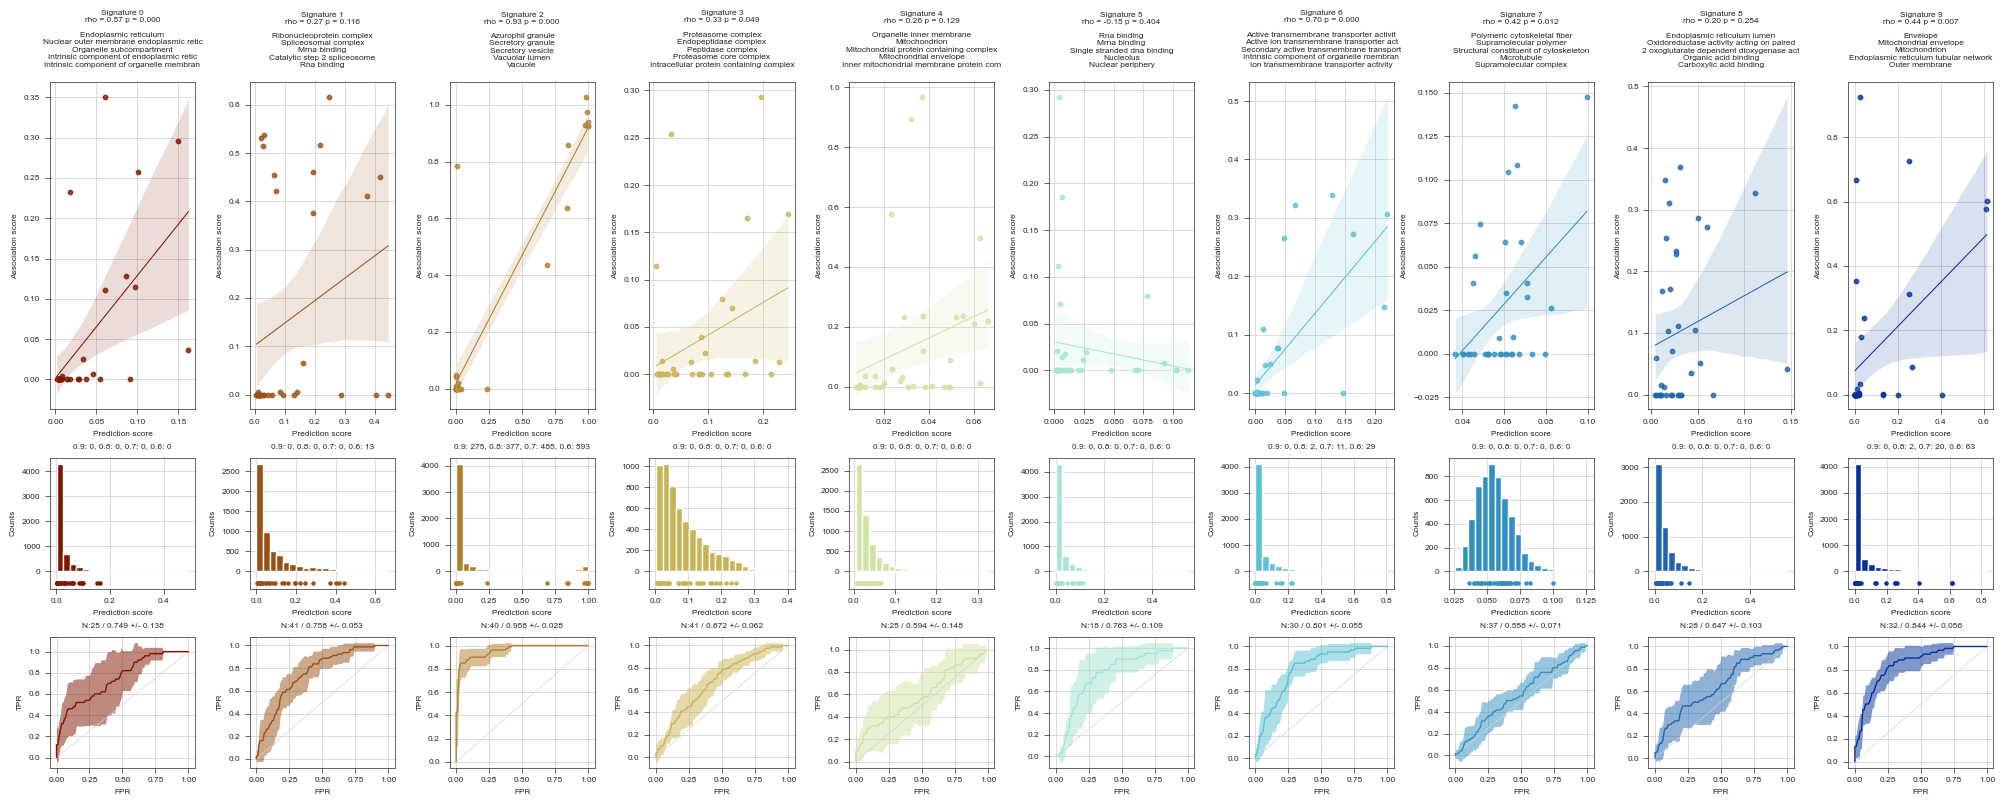

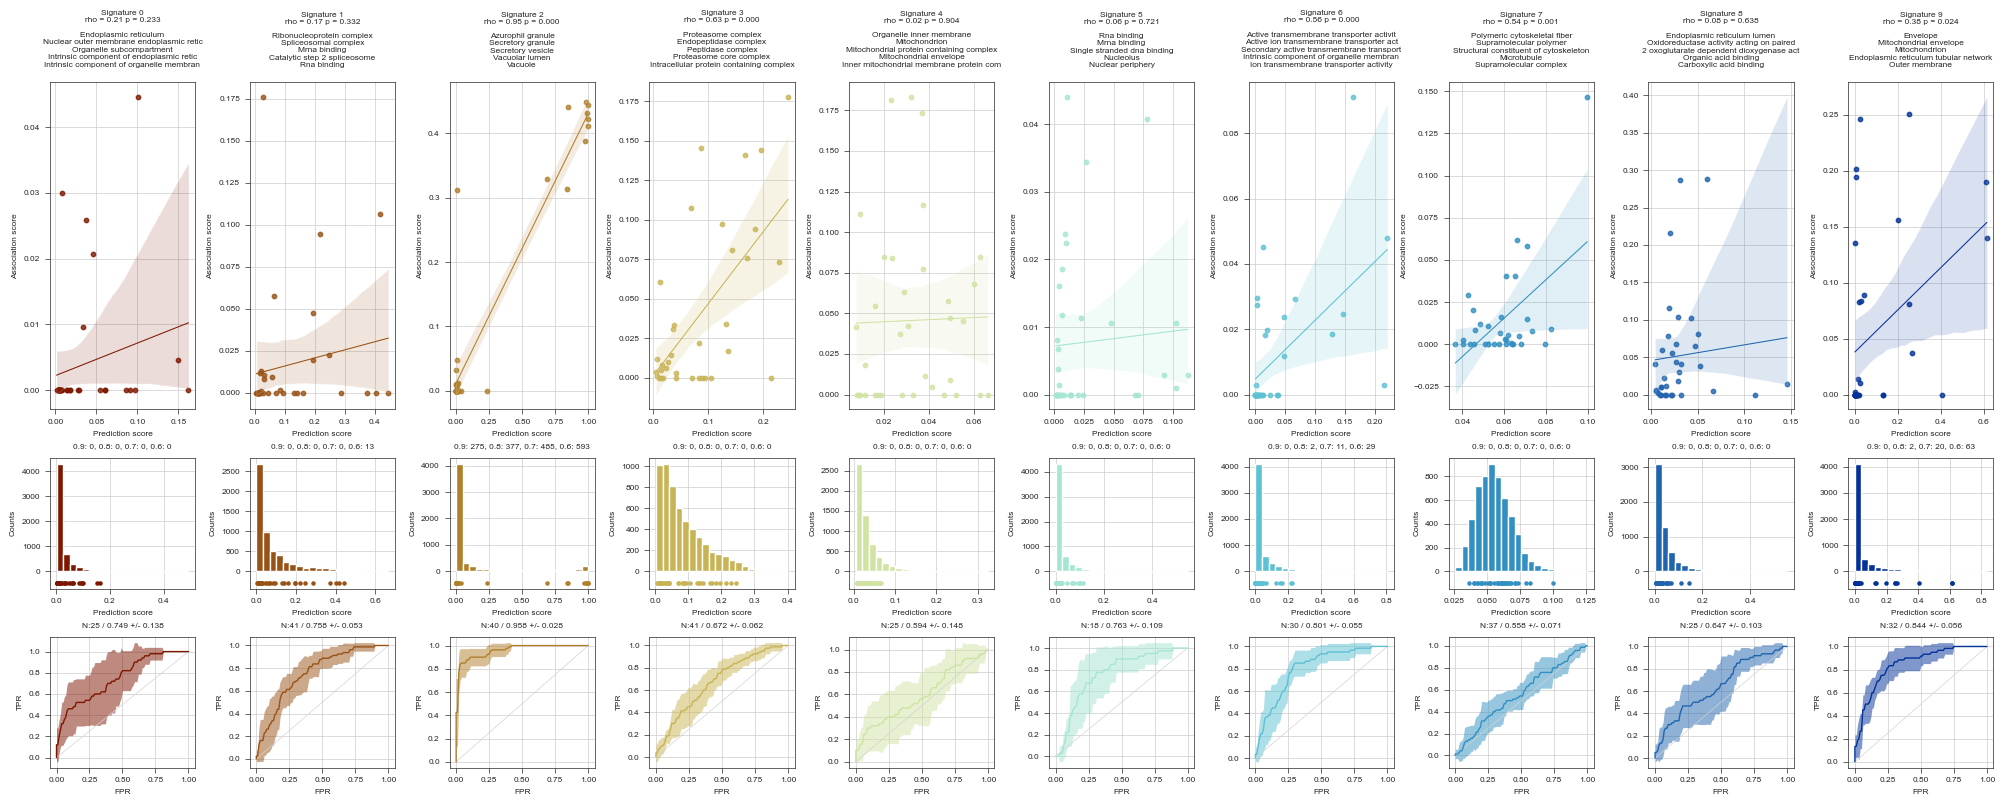

In [32]:
W = data_for_wizard["pipeline"].transform(texts)
correlation_plots(W, sufix="filtered")
W = data_for_wizard["pipeline"].transform(texts_simple)
correlation_plots(W, sufix="top")
